In [2]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
import yfinance as yf

from neurotrader.download_data import download_df
from neurotrader.directional_change import directional_change
from neurotrader.perceptually_important import find_pips
from neurotrader.head_shoulders import find_hs_patterns, get_pattern_return, load_attributes, plot_hs

# Reversal Pattern Detection Algorithm
- Look at the 1 day intervals for now
- Want to look at min by min at some point
- Goal: If a pattern is detected, how much wieght should we give the buying/selling power of that pattern
- AKA HOW ACCURATE THAT PATTERN IS FOR a certain stock (Profit factor)
- See which patterns are most common
- Look for a way to add an "Early Detection" of a pattern

## TODO:
- Run each program to see output, see how to generate data we can add to neural network
- 

## How to apply to a neural network
- For a stock, determine what error threshold to use by calculating the profit factor on known data
-   HAVE TO OPTIMIZE HIS CODE FOR THIS APPROACH
- Determine most common pattern
- Determine most profitable pattern
- Determine most accurate pattern
- Find a way to detect patterns before the occure (test to see if market finishes the pattern)
- Mess with different exit methods. Those are the hyperparameters
- Run this on different stock

### Idea:
Train a NN to detect different patterns, testing different exit strategies on each pattern. Have it assign a buy/sell confidence value to these patterns. Then test this on unseen new data. Try to impliment flag detection here too

We can further test this by training the network on each stock individually, trying to make predictions off of early identification

# Testing Different Algorithms for finding local extrema
- Rolling Window
- Directional Change
- Perceptually Important Points

In [34]:
# Trendline parameter
lookback = 30
data = download_df('AAPL', '5y')
data.head(1)

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,adj_high,adj_low
Date,,,,,,,,
2019-04-18,50.779999,51.037498,50.630001,50.965,49.063946,96783200,49.13374,48.741443


In [18]:
# ROLLING WINDOW ALGORITHM
# Use Scipy to get local extrema. BE CAREFUL NOT TO CHEAT WITH FUTURE DATA
# Use close data because it is more stable than adj high and adj low
arr = data['close'].to_numpy()
bottoms = scipy.signal.argrelextrema(arr, np.less, order=3)
tops = scipy.signal.argrelextrema(arr, np.greater, order=3)
print(bottoms[0][0:11])
print(tops[0][0:11])

[  2  12  18  31  41  50  63  71  90 108 118]
[ 7 14 19 23 29 38 47 57 69 77 87]


In [79]:
# Perceptually Important Points
PIP = 10
pips_x, pips_y = find_pips(arr, PIP, 1)
print(pips_x)
print(pips_y)

NameError: name 'arr' is not defined

# Building an ML model to detect patterns in a rolling window.
Abstract: We want to use mathematical equations to detect patterns in our stock data in our data. We will look at those patterns and tie a value to them. We will then use a rolling window technique to make calculations on unseen data???
- Use a 72-hour trend rolling window
- LOOK FOR FEATURES that could show a trend
- The Head and Shoulders is not a common occurance. Look to suplement this data with other patterns?
- A lot of papers and programs create a bunch of synthetic data to train models on
- This might be the best option here.

### 1) Head and Shoulders
- Possible option: Loop through every single one of the stock market top 500 and find the patterns. See how many there are?

In [68]:
ticker = 'AAPL'
data = download_df(ticker=ticker, interval='1d', period='max')

[*********************100%%**********************]  1 of 1 completed


In [100]:
# Detect HS in our dataset:
# Convert our data to a logorithmic form and then only select the "close" column
data_norm = np.log(data)
dat_slice = data_norm['close'].to_numpy()

# Find HS Patterns:
hs_patterns, ihs_patterns = find_hs_patterns(dat_slice, 6, early_find=False)
hs_df = pd.DataFrame()
hs_df = load_attributes(dat_slice, hs_df, hs_patterns, len(data))
ihs_df = pd.DataFrame()
ihs_df = load_attributes(dat_slice, ihs_df, ihs_patterns, len(data))

print(f"We detected {len(hs_patterns)} hs and {len(ihs_patterns)}"
      f" inverted hs out of {len(data)} data points")
print(f"Data time range: {data.index[0]} to {data.index[-1]}")

We detected 8 hs and 10 inverted hs out of 10928 data points
Data time range: 1980-12-12 00:00:00 to 2024-04-18 00:00:00


In [114]:
hs_patterns[0]

HSPattern(inverted=False, l_shoulder=484, r_shoulder=514, l_armpit=491, r_armpit=507, head=501, l_shoulder_p=-1.915141394764559, r_shoulder_p=-1.9227455795220403, l_armpit_p=-2.074987445643639, r_armpit_p=-2.070553218792868, head_p=-1.888966675277697, start_i=476, break_i=523, break_p=-2.0974588854344764, neck_start=-2.079144533316237, neck_end=-2.0661189919420972, neck_slope=0.00027713917817318023, head_width=16, head_height=0.18324937858420998, pattern_r2=0.6268341368808965)

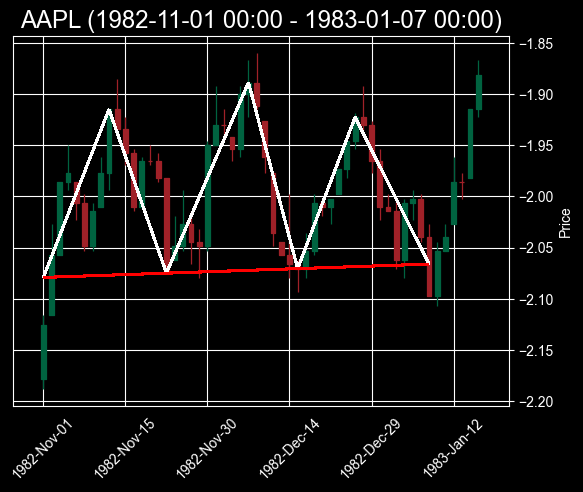

In [102]:
plot_hs(data_norm, ticker, hs_patterns[0], pad=6)

### Goal Here
1) Test to see how the model when trained on hourly, minute, and daily data
2) Train the data on both synthetic and real data. See how that effects pattern recognition
    - NEED TO LEARN HOW TO GENERATE SYNTHETIC STOCK DATA
3) TEST ALL THREE HS CALCULATIONS TO SEE WHICH ONE IS MORE ROBUST/ACCURATE!!!!
    - Neurotraders
    - CodeTrading
    - Medium's
4) Investigate the approach given by the paper from Seoul National University
    - This may not be useful because they use a ton of different patterns. Interesting read about what type of model to use
5) Have Neural Network add a buy/sell weight to each pattern after seeing if the stock went up or down after. Need to add manually?


BREAK DATA INTO TRAINING AND TEST DATA FOR REAL DATA
FOR SYNTHETIC DATA, TEST ON SAME TESTING DATA AS OTHER MODEL.

TODO RIGHT NOW: Break data up in a way that Neurotraders detection algorithm can work on a set of 500!!!


In [56]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Get the data for these tickers from yahoo finance
# yf_top500 = yf.download(tickers.Symbol.to_list(), interval='60m', period='2y', auto_adjust=True)['Close']

In [60]:
# Get the data for these tickers from yahoo finance
# Downloading this data because it is very time-consuming and I don't want to make 
#   repeated calls to yfinance
# COMMENTING OUT TO AVOID DOING THIS AGAIN
# for ticker in tickers.Symbol.to_list():
#     df = download_df(ticker=ticker, period='2y', interval='60m')
#     ticker_name = 'data/' + ticker + '_data.csv'
#     df.to_csv(ticker_name, index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [168]:
# Create a dictionary to store data
# Use ticker names as key
l_yf_top500_norm = {}
# For each ticker
for ticker in tickers.Symbol.to_list()[0:5]:
    try:
        # Get the data from the local files and apply logarithmic transformations to it
        data = pd.read_csv('data/' + ticker + '_data.csv', index_col=None, header=0)
        # Place the datetime in a temp dataset
        temp = data['Datetime']
        # Apply numeric and log to the data
        data = data.apply(pd.to_numeric, errors='coerce')
        data = np.log(data)
        # Add the datetime we saved earlier back in
        data['Datetime'] = temp
        data.index = pd.DatetimeIndex(data['Datetime'])
        # Get the close data and find the HS and IHS patterns
        dat_slice = data['close'].to_numpy()
        hs_patterns, ihs_patterns = find_hs_patterns(dat_slice, 6, early_find=False)
        # # hs_df = pd.DataFrame()
        # # ihs_df = pd.DataFrame()
        # # hs_df = load_attributes(dat_slice, hs_df, hs_patterns, len(data))
        # # ihs_df = load_attributes(dat_slice, ihs_df, ihs_patterns, len(data))
        # Store the data, hs, IHS with the ticker name as key
        l_yf_top500_norm.update({ticker: [data, hs_patterns, ihs_patterns]})
    except Exception as e:
        print(f"Failed on ticker {ticker} with exception {e}")
        continue

In [169]:
for i in l_yf_top500_norm:
    if i == "MMM":
        print(f"For ticker {i} there are {len(l_yf_top500_norm[i][1])} hs patterns and "
              f"{len(l_yf_top500_norm[i][2])} inverted hs patterns")

For ticker MMM there are 1 hs patterns and 3 inverted hs patterns


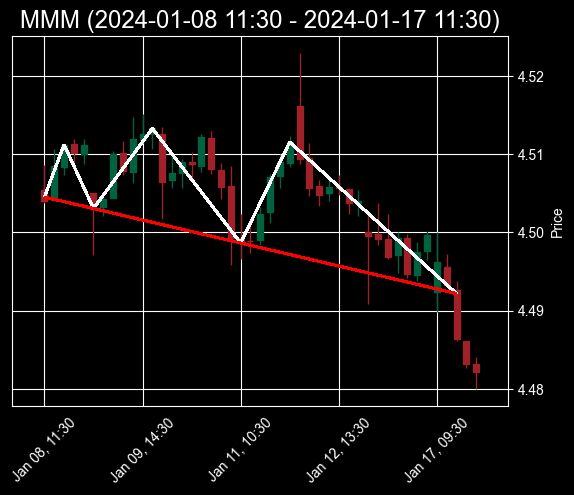

In [177]:
# Select the data from the dataframe using the ticker name as a key
# Get the hs pattern
candle_data = l_yf_top500_norm['MMM'][0]
pat = l_yf_top500_norm['MMM'][1][0]
plot_hs(candle_data, 'MMM', pat, 2)

# 2) Harmonic Patterns
- Add if I have time

In [17]:
from neurotrader.harmonic_patterns import get_extremes, find_xabcd, XABCD

GARTLEY = XABCD(0.618, [0.382, 0.886], [1.13, 1.618], 0.786, "Gartley")
BAT = XABCD([0.382, 0.50], [0.382, 0.886], [1.618, 2.618], 0.886, "Bat")
# ALT_BAT = XABCD(0.382, [0.382, 0.886], [2.0, 3.618], 1.13, "Alt Bat")
BUTTERFLY = XABCD(0.786, [0.382, 0.886], [1.618, 2.24], [1.27, 1.41], "Butterfly")
CRAB = XABCD([0.382, 0.618], [0.382, 0.886], [2.618, 3.618], 1.618, "Crab")
DEEP_CRAB = XABCD(0.886, [0.382, 0.886], [2.0, 3.618], 1.618, "Deep Crab")
CYPHER = XABCD([0.382, 0.618], [1.13, 1.41], [1.27, 2.00], 0.786, "Cypher")
SHARK = XABCD(None, [1.13, 1.618], [1.618, 2.24], [0.886, 1.13], "Shark")
ALL_PATTERNS = [GARTLEY, BAT, BUTTERFLY, CRAB, DEEP_CRAB, CYPHER, SHARK]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


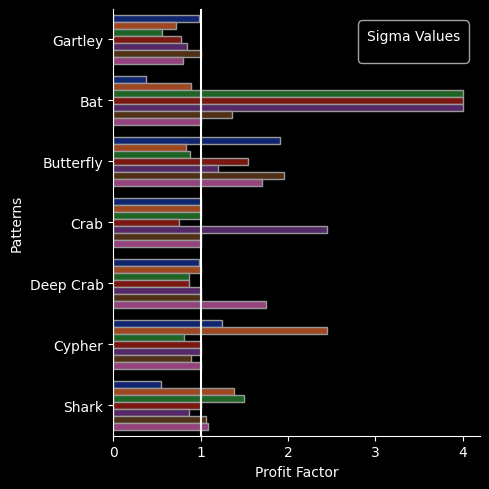

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


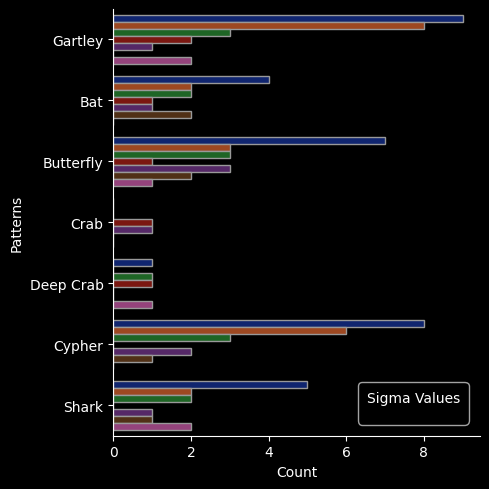

In [20]:
sigmas = []
patterns = []
pfs = []
counts = []
#for sigma in [0.01, 0.02, 0.03, 0.04]: 
for sigma in [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]: 
  extremes = get_extremes(data, sigma)
  output =  find_xabcd(data, extremes, 0.2)
  for pat in ALL_PATTERNS:
      sig = output[pat.name]['bear_signal'] + output[pat.name]['bull_signal']
      count = len(output[pat.name]['bear_patterns']) + len(output[pat.name]['bull_patterns'])
      rets = (data['r'] * sig)
      pf = rets[rets > 0].sum() / rets[rets < 0].abs().sum()
      if np.isnan(pf): # Set nan value to a neutral 1.0 for profit factor
          pf = 1.0

      if pf > 4.0: # put a ceil at 4, as that high of PF is from low sample size. Makes graph look better 
          pf = 4.0

      sigmas.append(sigma)
      patterns.append(pat.name)
      pfs.append(pf)
      counts.append(count)

import seaborn as sns 
df = pd.DataFrame()
df['sigmas'] = sigmas
df['Patterns'] = patterns
df['Profit Factor'] = pfs
df['Count'] = counts

plt.style.use('dark_background')
sns.catplot(
  data=df, y="Patterns", x='Profit Factor', hue="sigmas", kind='bar',
  palette="dark", edgecolor=".6", legend=False
)
plt.axvline(1.0, color='white')
plt.legend(prop={'size': 16}, title='Sigma Values')
plt.show()

sns.catplot(
  data=df, y="Patterns", x='Count', hue="sigmas", kind='bar',
  palette="dark", edgecolor=".6", legend=False
)
plt.legend(prop={'size': 16}, title='Sigma Values')
plt.show()